# Install

In [ ]:
!pip install alpha_vantage

In [ ]:
!pip install wandb

# Login en wandb

In [ ]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import wandb
from torch.utils.data import DataLoader, Dataset
from alpha_vantage.timeseries import TimeSeries
from sklearn.preprocessing import MinMaxScaler

# Importar Datos

In [ ]:
# Configuración de la API y los parámetros
API_KEY = '$$$'
symbol = 'SPY'
interval = '1min'  # Intervalo de tiempo: '1min', '5min', '15min', '30min', '60min'
outputsize = 'full'  # 'compact' para datos más recientes o 'full' para todos los datos históricos

# Crear un objeto TimeSeries de la biblioteca alpha_vantage
ts = TimeSeries(key=API_KEY, output_format='pandas')

# Obtener los datos intradía
data, meta_data = ts.get_intraday(symbol=symbol, interval=interval, outputsize=outputsize)

# Visualización Basica de Datos

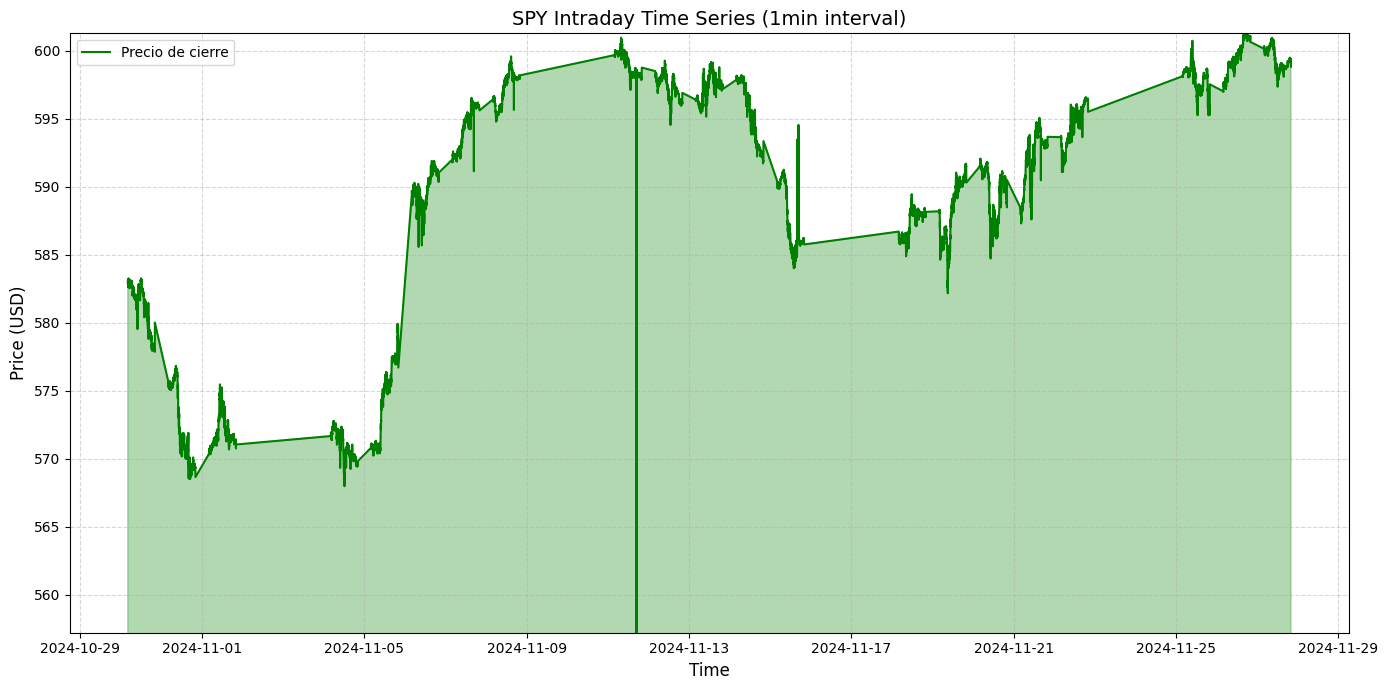

In [ ]:
plt.figure(figsize=(14, 7))

# Graficar el precio de cierre
plt.plot(data.index, data['4. close'], label='Precio de cierre', color='green')

# Agregar el degradado debajo de la gráfica con color verde
plt.fill_between(data.index, data['4. close'], color='green', alpha=0.3)

# Ajustar los límites del eje y para incluir 0, si no está ya en el rango
plt.ylim([data['4. close'].min(), data['4. close'].max()])

# Configurar el título y las etiquetas
plt.title(f'{symbol} Intraday Time Series ({interval} interval)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar cuadrícula con estilo
plt.legend()
plt.tight_layout()
plt.show()

# Separamos los Datos

In [ ]:
def train_val_test_split(data, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2):
    """
    Divide los datos en conjuntos de entrenamiento, validación y prueba.
    """
    assert train_ratio + val_ratio + test_ratio == 1, "Ratios deben sumar 1"

    n = len(data)
    train_end = int(train_ratio * n)
    val_end = train_end + int(val_ratio * n)

    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    return train_data, val_data, test_data

# Escalamos los Datos

In [ ]:
def scale_data(train, val, test):
    """
    Escala los datos a [0, 1] usando solo el conjunto de entrenamiento.
    """
    scaler = MinMaxScaler(feature_range=(-1, 1))
    train_scaled = scaler.fit_transform(train.to_numpy().reshape(-1, 1)).flatten()
    val_scaled = scaler.transform(val.to_numpy().reshape(-1, 1)).flatten()
    test_scaled = scaler.transform(test.to_numpy().reshape(-1, 1)).flatten()
    data_min = scaler.data_min_[0]  # Mínimo
    data_max = scaler.data_max_[0]  # Máximo

    return train_scaled, val_scaled, test_scaled, data_min, data_max

# Realizamos la función para crear las ventanas

In [ ]:
def create_windows(data, window_size):
    """
    Crea ventanas deslizantes a partir de los datos escalados.
    """
    df = pd.Series(data).to_frame()
    series = pd.Series(data)
    for i in range(1, window_size + 1):
        df[f'Close(t-{i})'] = series.shift(i)
    df.dropna(inplace=True)
    df = df.rename(columns={0: 'regression_label'})
    return df

# Realizamos la funcion para añadir la columna classification label.

In [ ]:
def compare_regression_and_close(df):
    """
    Compara la columna 'regression_label' con 'Close{t-1}' en un DataFrame.
    Asigna 1 si son iguales, 0 si no, y añade una nueva columna 'comparison_result'.
    """
    if 'regression_label' not in df or 'Close(t-1)' not in df:
        raise ValueError("El DataFrame debe contener las columnas 'regression_label' y 'Close(t-1)'.")

    # Comparar las columnas y asignar resultados
    df['classification_label'] = (df['regression_label'] > df['Close(t-1)']).astype(int)

    columns = ['classification_label'] + [col for col in df.columns if col != 'classification_label']
    df = df[columns]

    return df

# Preparamos todos los Datos

In [ ]:
def prepare_data(data, window_size, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2, scaled = True):
    """
    Convierte un array en ventanas deslizantes, lo divide en conjuntos y escala los datos.
    """
    train_data, val_data, test_data = train_val_test_split(data, train_ratio, val_ratio, test_ratio)
    data_min = 0
    data_max = 0
    if(scaled):
      # Escalar los datos
      train_scaled, val_scaled, test_scaled, data_min, data_max = scale_data(train_data, val_data, test_data)
    else:
      train_scaled = train_data.to_numpy().flatten()
      val_scaled = val_data.to_numpy().flatten()
      test_scaled = test_data.to_numpy().flatten()

    # Crear ventanas deslizantes en forma de DataFrame
    df_train = create_windows(train_scaled, window_size)
    df_val = create_windows(val_scaled, window_size)
    df_test = create_windows(test_scaled, window_size)

    df_train = compare_regression_and_close(df_train)
    df_val = compare_regression_and_close(df_val)
    df_test = compare_regression_and_close(df_test)



    return df_train, df_val, df_test, data_min, data_max

# Definimos la clase para crear los dataset personalizados

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, window_size):
        self.features = dataframe.drop(["regression_label", "classification_label"], axis=1).values
        self.regression_label = dataframe["regression_label"].values
        self.classification_label = dataframe["classification_label"].values
        self.window_size = window_size
    def __len__(self):
        # Número de muestras en el dataset
        return len(self.features)

    def __getitem__(self, idx):
        # Extraer características y etiquetas para una muestra específica
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        regression_label = torch.tensor(self.regression_label[idx], dtype=torch.float32)
        classification_label = torch.tensor(self.classification_label[idx], dtype=torch.float32)
        return features, regression_label, classification_label

# Definimos la función para crear los Dataloader

In [ ]:
def create_dataloader(dataframe, window_size, batch_size=32, shuffle=True):
    dataset = CustomDataset(dataframe, window_size)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader

# Definimos los Transformers

In [ ]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

In [ ]:
class TransformerModelRC(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModelRC, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.classification_head = nn.Linear(d_model, 1)
        self.regression_head = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        last_time_step = x[:, -1, :]
        classification_output = torch.sigmoid(self.classification_head(last_time_step))
        regression_output = self.regression_head(last_time_step)
        return classification_output, regression_output

In [ ]:
class TransformerR(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerR, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.regression_head = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        last_time_step = x[:, -1, :]
        regression_output = self.regression_head(last_time_step)
        return regression_output


In [ ]:
class TransformerC(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerC, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.classification_head = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        last_time_step = x[:, -1, :]
        classification_output = torch.sigmoid(self.classification_head(last_time_step))
        return classification_output


# Metricas

In [ ]:
def accuracy_score_torch(y_true, y_pred, threshold=0.5):
    """
    Calcula la precisión (accuracy) usando tensores de PyTorch.
    """
    y_pred_labels = (y_pred > threshold).float()
    correct_predictions = (y_pred_labels == y_true).float()
    accuracy = correct_predictions.mean()
    return accuracy.item()

In [ ]:
def r2_score_torch(y_true, y_pred):
    """
    Calcula el R^2 (coeficiente de determinación) en PyTorch.
    """
    ss_total = torch.sum((y_true - torch.mean(y_true)) ** 2)
    ss_residual = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_residual / ss_total)
    return r2.item()

# Definimos la función para realizar los experimentos

# Entrenamiento del transformer RC

In [ ]:
def train_experiment(config=None):
    with wandb.init(project="transformerRC", config=config):
        config = wandb.config

        # Modelo, optimizador, y pérdida
        model = TransformerModelRC(
            input_dim=config.window_size,
            d_model=config.d_model,
            nhead=config.nhead,
            num_layers=config.num_layers,
            dropout=config.dropout,
        ).to(config.device)

        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=5, verbose=True
        )
        criterion_classification = torch.nn.BCELoss()
        criterion_regression = torch.nn.MSELoss()

        # Dataset y DataLoader
        df_train, df_val, df_test, data_min, data_max = prepare_data(data['4. close'], config.window_size)
        train_loader = create_dataloader(df_train, config.window_size, batch_size=config.batch_size, shuffle=True)
        val_loader = create_dataloader(df_val, config.window_size, batch_size=config.batch_size, shuffle=False)

        # Crear un artefacto de dataset
        test_dataset_artifact = wandb.Artifact("test_dataset", type="dataset")

        # Convertir el DataFrame a un wandb.Table
        test_table = wandb.Table(dataframe=df_test)

        # Añadir la tabla al artefacto
        test_dataset_artifact.add(test_table, "test_data")

        # Subir el artefacto a wandb
        wandb.log_artifact(test_dataset_artifact)

        wandb.config.data_min = data_min
        wandb.config.data_max = data_max

        # Variables para guardar el mejor modelo
        best_val_loss = float('inf')
        best_model_path = "best_model.pth"
        last_model_path = "last_model.pth"

        for epoch in range(config.epochs):
            # Modo entrenamiento
            model.train()
            epoch_loss_classification = 0
            epoch_loss_regression = 0
            epoch_loss_total = 0
            epoch_accuracy = 0

            for features, regression_label, classification_label in train_loader:
                inputs = features.to(config.device)
                classification_targets = classification_label.to(config.device)
                regression_targets = regression_label.to(config.device)

                optimizer.zero_grad()

                # Forward
                classification_output, regression_output = model(inputs)

                # Calcular pérdidas
                loss_classification = criterion_classification(
                    classification_output, classification_targets.unsqueeze(1)
                )
                loss_regression = criterion_regression(
                    regression_output, regression_targets.unsqueeze(1)
                )

                loss = 0.10*loss_classification + loss_regression

                epoch_loss_classification += loss_classification.item()
                epoch_loss_regression += loss_regression.item()
                epoch_loss_total += loss.item()

                # Backward
                loss.backward()
                optimizer.step()

                # Calcular métricas
                accuracy = accuracy_score_torch(classification_targets, classification_output)

                epoch_accuracy += accuracy

            # Promediar métricas de entrenamiento por epoch
            avg_loss_classification = epoch_loss_classification / len(train_loader)
            avg_loss_regression = epoch_loss_regression / len(train_loader)
            avg_loss_total = epoch_loss_total / len(train_loader)
            avg_accuracy = epoch_accuracy / len(train_loader)

            # Modo evaluación (validación)
            model.eval()
            val_loss_classification = 0
            val_loss_regression = 0
            val_loss_total = 0
            val_accuracy = 0

            with torch.no_grad():
                for features, regression_label, classification_label in val_loader:
                    inputs = features.to(config.device)
                    classification_targets = classification_label.to(config.device)
                    regression_targets = regression_label.to(config.device)

                    # Forward
                    classification_output, regression_output = model(inputs)

                    # Calcular pérdidas
                    loss_classification = criterion_classification(
                        classification_output, classification_targets.unsqueeze(1)
                    )
                    loss_regression = criterion_regression(
                        regression_output, regression_targets.unsqueeze(1)
                    )

                    loss = 0.10*loss_classification + loss_regression

                    val_loss_classification += loss_classification.item()
                    val_loss_regression += loss_regression.item()
                    val_loss_total += loss.item()

                    # Calcular métricas
                    accuracy = accuracy_score_torch(classification_targets, classification_output)

                    val_accuracy += accuracy

            # Promediar métricas de validación por epoch
            avg_val_loss_classification = val_loss_classification / len(val_loader)
            avg_val_loss_regression = val_loss_regression / len(val_loader)
            avg_val_loss_total = val_loss_total / len(val_loader)
            avg_val_accuracy = val_accuracy / len(val_loader)

            scheduler.step(avg_val_loss_total)

            # Registrar métricas en WandB
            wandb.log({
                "epoch": epoch,
                "train_loss_total": avg_loss_total,
                "train_loss_classification": avg_loss_classification,
                "train_loss_regression": avg_loss_regression,
                "train_accuracy": avg_accuracy,
                "val_loss_total": avg_val_loss_total,
                "val_loss_classification": avg_val_loss_classification,
                "val_loss_regression": avg_val_loss_regression,
                "val_accuracy": avg_val_accuracy,
            })

            # Guardar el mejor modelo según la pérdida de validación
            if avg_val_loss_total < best_val_loss:
                best_val_loss = avg_val_loss_total
                torch.save(model.state_dict(), best_model_path)
                # Crear un artefacto para el mejor modelo
                best_model_artifact = wandb.Artifact("best_model", type="model")
                best_model_artifact.add_file(best_model_path)

                # Registrar el artefacto
                wandb.log_artifact(best_model_artifact)

        # Guardar el último modelo al final del entrenamiento
        torch.save(model.state_dict(), last_model_path)

        # Crear un artefacto para el último modelo
        last_model_artifact = wandb.Artifact("last_model", type="model")
        last_model_artifact.add_file(last_model_path)

        # Registrar el artefacto
        wandb.log_artifact(last_model_artifact)


# Entrenamiento del transformer C

In [ ]:
def train_classification_experiment(config=None):
    with wandb.init(project="transformerC", config=config):
        config = wandb.config

        # Modelo, optimizador, y pérdida
        model = TransformerC(
            input_dim=config.window_size,
            d_model=config.d_model,
            nhead=config.nhead,
            num_layers=config.num_layers,
            dropout=config.dropout,
        ).to(config.device)

        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=5, verbose=True
        )
        criterion = torch.nn.BCELoss()

        # Dataset y DataLoader
        df_train, df_val, df_test,_,_ = prepare_data(data['4. close'], config.window_size, scaled = False)
        train_loader = create_dataloader(df_train, config.window_size, batch_size=config.batch_size, shuffle=True)
        val_loader = create_dataloader(df_val, config.window_size, batch_size=config.batch_size, shuffle=False)

        # Subir dataset de testeo como artefacto en wandb
        test_artifact = wandb.Artifact("test_dataset", type="dataset")
        test_table = wandb.Table(dataframe=df_test)
        test_artifact.add(test_table, "test_data")
        wandb.log_artifact(test_artifact)

        # Variables para el mejor modelo
        best_val_loss = float("inf")
        best_model_path = "best_classification_model.pth"
        last_model_path = "last_classification_model.pth"

        for epoch in range(config.epochs):
            model.train()
            epoch_loss = 0
            epoch_accuracy = 0

            for features, _, labels in train_loader:
                inputs = features.to(config.device)
                targets = labels.to(config.device)

                optimizer.zero_grad()

                # Forward y cálculo de pérdida
                outputs = model(inputs)
                loss = criterion(outputs, targets.unsqueeze(1))

                # Backward y optimización
                loss.backward()
                optimizer.step()

                # Métricas
                epoch_loss += loss.item()

                # Calcular métricas
                accuracy = accuracy_score_torch(targets, outputs)

                epoch_accuracy += accuracy

            # Promediar métricas de entrenamiento
            avg_loss = epoch_loss / len(train_loader)
            avg_accuracy = epoch_accuracy / len(train_loader)

            # Validación
            model.eval()
            val_loss = 0
            val_accuracy = 0
            with torch.no_grad():
                for features, _, labels in val_loader:
                    inputs = features.to(config.device)
                    targets = labels.to(config.device)

                    outputs = model(inputs)
                    loss = criterion(outputs, targets.unsqueeze(1))

                    val_loss += loss.item()
                    # Calcular métricas
                    accuracy = accuracy_score_torch(targets, outputs)

                    val_accuracy += accuracy

            avg_val_loss = val_loss / len(val_loader)
            avg_val_accuracy = val_accuracy / len(val_loader)

            scheduler.step(avg_val_loss)

            # Log en wandb
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_loss,
                "train_accuracy": avg_accuracy,
                "val_loss": avg_val_loss,
                "val_accuracy": avg_val_accuracy,
            })

            # Guardar el mejor modelo
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), best_model_path)
                best_model_artifact = wandb.Artifact("best_classification_model", type="model")
                best_model_artifact.add_file(best_model_path)
                wandb.log_artifact(best_model_artifact)

        # Guardar el último modelo
        torch.save(model.state_dict(), last_model_path)
        last_model_artifact = wandb.Artifact("last_classification_model", type="model")
        last_model_artifact.add_file(last_model_path)
        wandb.log_artifact(last_model_artifact)

# Entrenamiento del transformer R

In [ ]:
def train_regression_experiment(config=None):
    with wandb.init(project="transformerR", config=config):
        config = wandb.config

        # Modelo, optimizador, y pérdida
        model = TransformerR(
            input_dim=config.window_size,
            d_model=config.d_model,
            nhead=config.nhead,
            num_layers=config.num_layers,
            dropout=config.dropout,
        ).to(config.device)

        optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.5, patience=5, verbose=True
        )
        criterion = torch.nn.MSELoss()

        # Dataset y DataLoader
        df_train, df_val, df_test, data_min, data_max = prepare_data(data['4. close'], config.window_size)
        train_loader = create_dataloader(df_train, config.window_size, batch_size=config.batch_size, shuffle=True)
        val_loader = create_dataloader(df_val, config.window_size, batch_size=config.batch_size, shuffle=False)

        # Subir dataset de testeo como artefacto en wandb
        test_artifact = wandb.Artifact("test_dataset", type="dataset")
        test_table = wandb.Table(dataframe=df_test)
        test_artifact.add(test_table, "test_data")
        wandb.log_artifact(test_artifact)

        # Guardar data_min y data_max
        wandb.config.data_min = data_min
        wandb.config.data_max = data_max

        # Variables para el mejor modelo
        best_val_loss = float("inf")
        best_model_path = "best_regression_model.pth"
        last_model_path = "last_regression_model.pth"

        for epoch in range(config.epochs):
            # Entrenamiento
            model.train()
            epoch_loss = 0
            epoch_r2 = 0

            for features, labels, _ in train_loader:
                inputs = features.to(config.device)
                targets = labels.to(config.device)

                optimizer.zero_grad()

                # Forward y cálculo de pérdida
                outputs = model(inputs)
                loss = criterion(outputs, targets.unsqueeze(1))

                # Backward y optimización
                loss.backward()
                optimizer.step()

                # Métricas
                epoch_loss += loss.item()
                r2 = r2_score_torch(targets, outputs)
                epoch_r2 += r2

            # Promediar métricas de entrenamiento
            avg_loss = epoch_loss / len(train_loader)
            avg_r2 = epoch_r2 / len(train_loader)

            # Validación
            model.eval()
            val_loss = 0
            val_r2 = 0
            with torch.no_grad():
                for features, labels, _ in val_loader:
                    inputs = features.to(config.device)
                    targets = labels.to(config.device)

                    outputs = model(inputs)
                    loss = criterion(outputs, targets.unsqueeze(1))

                    val_loss += loss.item()
                    r2 = r2_score_torch(targets, outputs)
                    val_r2 += r2

            avg_val_loss = val_loss / len(val_loader)
            avg_val_r2 = val_r2 / len(val_loader)

            scheduler.step(avg_val_loss)

            # Log en wandb
            wandb.log({
                "epoch": epoch,
                "train_loss": avg_loss,
                "train_r2": avg_r2,
                "val_loss": avg_val_loss,
                "val_r2": avg_val_r2,
            })

            # Guardar el mejor modelo
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save(model.state_dict(), best_model_path)
                best_model_artifact = wandb.Artifact("best_regression_model", type="model")
                best_model_artifact.add_file(best_model_path)
                wandb.log_artifact(best_model_artifact)

        # Guardar el último modelo
        torch.save(model.state_dict(), last_model_path)
        last_model_artifact = wandb.Artifact("last_regression_model", type="model")
        last_model_artifact.add_file(last_model_path)
        wandb.log_artifact(last_model_artifact)

#Configurar las sweep

In [ ]:
sweep_config = {
    "method": "random",  # Exploración aleatoria
    "metric": {
        "name": "val_loss",  # Métrica a optimizar
        "goal": "minimize",  # Minimizar la pérdida de validación
    },
    "parameters": {
        "d_model": {"values": [64, 128, 256]},  # Dimensión del modelo
        "nhead": {"values": [4, 8, 16]},  # Número de cabezas
        "num_layers": {"values": [8, 12, 16]},  # Número de capas del encoder
        "dropout": {"values": [0.1, 0.2, 0.3]},  # Dropout
        "lr": {"values": [1e-4, 5e-4, 1e-3, 5e-3]},  # Learning rate inicial
        "batch_size": {"values": [128]},  # Tamaño del batch
        "window_size": {"values": [30, 60, 90, 120]},  # Tamaño de la ventana
        "epochs": {"values": [50]}, # Número de epocas
        "device": {"value": "cuda" if torch.cuda.is_available() else "cpu"}
    }
}

In [ ]:
sweep_id = wandb.sweep(sweep=sweep_config, project="transformerC")
wandb.agent(sweep_id, train_classification_experiment, count=10)
sweep_id_2 = wandb.sweep(sweep=sweep_config, project="transformerR")
wandb.agent(sweep_id_2, train_regression_experiment, count=10)
sweep_id_3 = wandb.sweep(sweep=sweep_config, project="transformerRC")
wandb.agent(sweep_id_3, train_experiment, count=10)

# Datos a 5 minutos

In [ ]:
# Configuración de la API y los parámetros
API_KEY = '$$'
symbol = 'SPY'
interval = '5min'  # Intervalo de tiempo: '1min', '5min', '15min', '30min', '60min'
outputsize = 'full'  # 'compact' para datos más recientes o 'full' para todos los datos históricos

# Crear un objeto TimeSeries de la biblioteca alpha_vantage
ts = TimeSeries(key=API_KEY, output_format='pandas')

# Obtener los datos intradía
data, meta_data = ts.get_intraday(symbol=symbol, interval=interval, outputsize=outputsize)

## Grafico de datos a 5 minutos

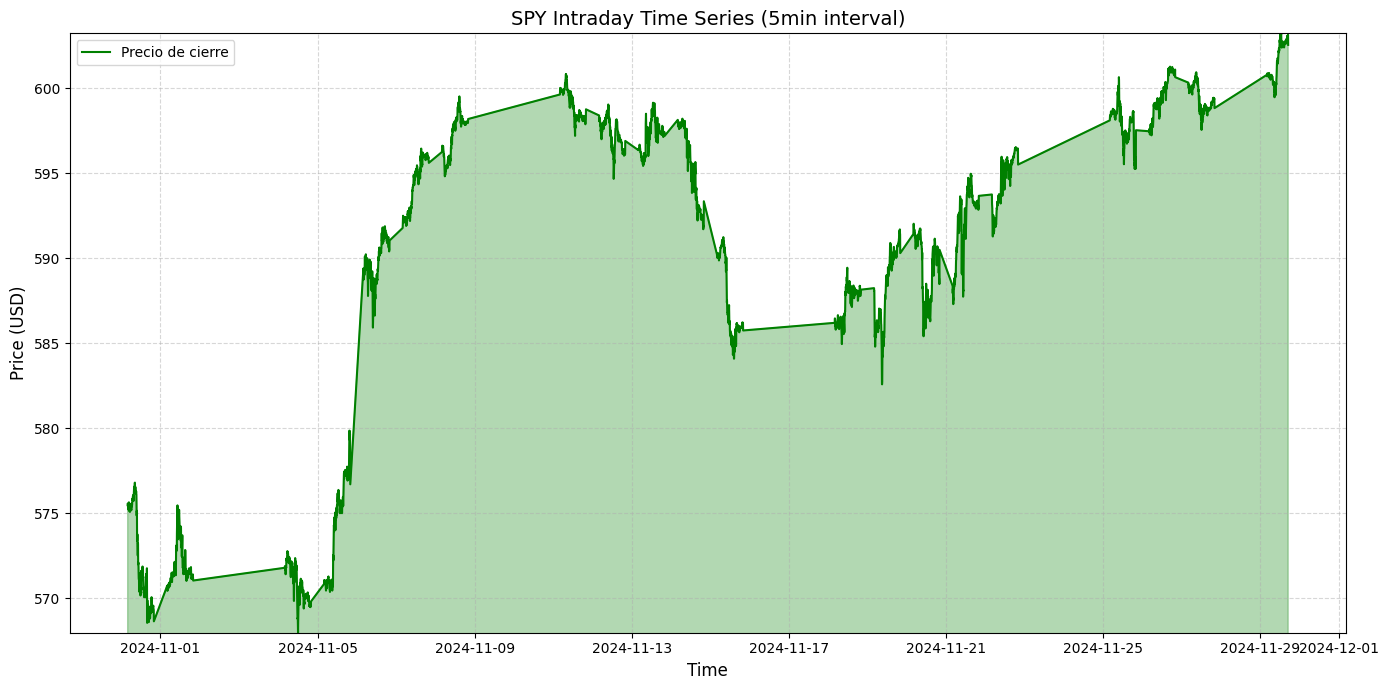

In [ ]:
plt.figure(figsize=(14, 7))

# Graficar el precio de cierre
plt.plot(data.index, data['4. close'], label='Precio de cierre', color='green')

# Agregar el degradado debajo de la gráfica con color verde
plt.fill_between(data.index, data['4. close'], color='green', alpha=0.3)

# Ajustar los límites del eje y para incluir 0, si no está ya en el rango
plt.ylim([data['4. close'].min(), data['4. close'].max()])

# Configurar el título y las etiquetas
plt.title(f'{symbol} Intraday Time Series ({interval} interval)', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.grid(visible=True, linestyle='--', alpha=0.5)  # Agregar cuadrícula con estilo
plt.legend()
plt.tight_layout()
plt.show()

# Cantidad de datos

In [ ]:
data["4. close"].shape

(4017,)

# Configurar sweeps para frecuencia con 5 minutos

In [ ]:
sweep_config_1 = {
    "method": "grid",  # Exploración aleatoria
    "metric": {
        "name": "val_loss",  # Métrica a optimizar
        "goal": "minimize",  # Minimizar la pérdida de validación
    },
    "parameters": {
        "d_model": {"values": [128]},  # Dimensión del modelo
        "nhead": {"values": [8]},  # Número de cabezas
        "num_layers": {"values": [16]},  # Número de capas del encoder
        "dropout": {"values": [0.2]},  # Dropout
        "lr": {"values": [1e-4]},  # Learning rate inicial
        "batch_size": {"values": [128]},  # Tamaño del batch
        "window_size": {"values": [30, 45, 60]},  # Tamaño de la ventana
        "epochs": {"values": [50]}, # Número de epocas
        "device": {"value": "cuda" if torch.cuda.is_available() else "cpu"}
    }
}

In [ ]:
sweep_id_4 = wandb.sweep(sweep=sweep_config_1, project="transformerC")
wandb.agent(sweep_id_4, train_classification_experiment, count=10)

In [ ]:
sweep_id_5 = wandb.sweep(sweep=sweep_config_1, project="transformerR")
wandb.agent(sweep_id_5,  train_regression_experiment, count=10)

In [ ]:
sweep_id_6 = wandb.sweep(sweep=sweep_config_1, project="transformerRC")
wandb.agent(sweep_id_6, train_experiment, count=10)